# AdaPTS with TimesFM: Multivariate Blood Glucose Forecasting with Adapters

**Model**: AdaPTS + TimesFM v1 (200M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)  

## About AdaPTS

[AdaPTS](https://github.com/abenechehab/AdaPTS) (ICML 2025) enables **multivariate probabilistic forecasting** by adapting univariate foundation models like TimesFM.

### How It Works

1. **Encode**: Project multivariate input (BG, IOB, COB, etc.) to a lower-dimensional latent space
2. **Forecast**: Apply the univariate FM independently to each latent dimension
3. **Decode**: Reconstruct multivariate predictions from latent forecasts

### Why This Matters for Blood Glucose

Univariate TimesFM only sees historical BG values. With AdaPTS, we can incorporate:
- **IOB** (Insulin on Board) - anticipate insulin-induced drops
- **COB** (Carbs on Board) - capture meal-related rises
- **Activity** (steps, calories) - account for exercise effects

## Environment Setup

**Important**: AdaPTS requires TimesFM v1 API and specific package versions. You need a separate environment from TimesFM 2.5.

```bash
# Create new environment for AdaPTS
python -m venv .venv-adapts
source .venv-adapts/bin/activate

# Install compatible versions (PyTorch 2.0.1 + NumPy 1.x required for AdaPTS)
pip install torch==2.0.1
pip install "numpy<2"

# Install TimesFM v1
pip install -e ./timesfm/v1

# Install AdaPTS
pip install git+https://github.com/abenechehab/AdaPTS.git

# Install project dependencies
pip install -e .
```

In [1]:
import sys
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path to local timesfm repo (adjust if needed)
TIMESFM_REPO = Path.cwd() / "timesfm"


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
CONTEXT_LENGTH = 512  # ~42 hours
TARGET_COL = ColumnNames.BG.value

prediction_length = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {prediction_length} steps ({NOCTURNAL_HOURS} hours)")
print(f"Context length: {CONTEXT_LENGTH} steps (~{CONTEXT_LENGTH * INTERVAL_MINS / 60:.0f} hours)")

Predicting 72 steps (6 hours)
Context length: 512 steps (~43 hours)


In [3]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data
train_data = loader.train_data

2026-01-21T16:51:53 - ============================================================
2026-01-21T16:51:53 - Beginning data loading process with the following parmeters:
2026-01-21T16:51:53 - 	Dataset: kaggle_brisT1D - train
2026-01-21T16:51:53 - 	Columns: None
2026-01-21T16:51:53 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-21T16:51:53 - 	Number of validation days: 20
2026-01-21T16:51:53 - 	In parallel with up to 3 workers.

2026-01-21T16:51:53 - Loaded full processed data from cache for 9 patients
2026-01-21T16:51:53 - Loaded existing train/validation split from cache for 9 patients


In [4]:
# Ensure TimesFM v1 path is in sys.path
timesfm_v1_path = str(TIMESFM_REPO / "v1" / "src")
if timesfm_v1_path not in sys.path:
    sys.path.insert(0, timesfm_v1_path)
    print(f"Added TimesFM v1 path: {timesfm_v1_path}")

# Import AdaPTS (which will use TimesFM v1)
from adapts.adapts import ADAPTS
from adapts.adapters import MultichannelProjector
from adapts.icl.timesfm import TimesFMICLTrainer, load_timesfm_model

print("AdaPTS imported successfully with TimesFM v1 backend")

# Multivariate features for blood glucose forecasting
FEATURES = [
    ColumnNames.BG.value,      # Blood glucose (target)
    ColumnNames.IOB.value,     # Insulin on board
    ColumnNames.COB.value,     # Carbs on board
    ColumnNames.STEPS.value,   # Physical activity
    ColumnNames.CALS.value,    # Calories burned
]
N_FEATURES = len(FEATURES)
N_COMPONENTS = 3  # Latent space dimensions (can tune this)

print(f"\nMultivariate features: {FEATURES}")
print(f"N features: {N_FEATURES} -> N components: {N_COMPONENTS}")

Added TimesFM v1 path: /Users/arohi/Desktop/FYDP/nocturnal-hypo-gly-prob-forecast/docs-internal/notebooks/timesfm/v1/src
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ].
AdaPTS imported successfully with TimesFM v1 backend

Multivariate features: ['bg_mM', 'iob', 'cob', 'steps', 'cals']
N features: 5 -> N components: 3


/Users/arohi/Desktop/FYDP/nocturnal-hypo-gly-prob-forecast/.venv-adapts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Initialize AdaPTS components

# 1. Load TimesFM model for AdaPTS (uses v1 API)
timesfm_model = load_timesfm_model(
    model_name="google/timesfm-2.0-500m-pytorch",
    forecast_horizon=prediction_length,
    context_length=CONTEXT_LENGTH,
)

# 2. Create ICL Trainer wrapper for TimesFM
icl_trainer = TimesFMICLTrainer(
    model=timesfm_model,
    n_features=N_COMPONENTS,  # Works in latent space
    forecast_horizon=prediction_length,
)

# 3. Create adapter (MultichannelProjector with VAE)
ADAPTER_TYPE = "VAE"

adapter = MultichannelProjector(
    num_channels=N_FEATURES,
    new_num_channels=N_COMPONENTS,
    base_projector=ADAPTER_TYPE,
    device=device,
    use_revin=False,  # Must be False - VAE has shape bug with use_revin=True
    context_length=CONTEXT_LENGTH,
    forecast_horizon=prediction_length,
)

# 4. Create ADAPTS model (disable scaler to avoid Pipeline fitting issues)
adapts_model = ADAPTS(
    adapter=adapter,
    iclearner=icl_trainer,
    n_features=N_FEATURES,
    n_components=N_COMPONENTS,
    scaler_in_preprocessing=False,
)

print(f"AdaPTS initialized with {ADAPTER_TYPE} adapter")
print(f"  Input: {N_FEATURES} features -> Latent: {N_COMPONENTS} components")

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 52560.20it/s]
/Users/arohi/Desktop/FYDP/nocturnal-hypo-gly-prob-forecast/.venv-adapts/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2026-01-21T16:51:59 - Loading checkpoint from /Users/arohi/.cache/huggingface/hub/models--google--timesfm-2.0-500m-pytorch/snapshots/dc2443792ce5516872b89b37cf1bc058c3bf0c10/torch_model.ckpt
2026-01-21T16:52:01 - Sending checkpoint to device cpu


AdaPTS initialized with VAE adapter
  Input: 5 features -> Latent: 3 components


## Prepare Training Data for Adapter

The adapter needs to learn how to project multivariate data into a latent space. We collect training windows from all patients to fit the adapter.

In [6]:
def prepare_multivariate_context(df: pd.DataFrame, features: list, context_length: int):
    """
    Prepare multivariate context from a patient DataFrame.
    
    Args:
        df: Patient DataFrame with all features
        features: List of feature column names
        context_length: Number of timesteps
        
    Returns:
        context: array of shape (n_features, context_length) or None if invalid
    """
    # Extract features
    context_df = df[features].copy()
    
    # Impute missing values
    for col in [ColumnNames.BG.value, ColumnNames.IOB.value, ColumnNames.COB.value]:
        if col in context_df.columns:
            context_df[col] = context_df[col].ffill().bfill()
    
    # Fill activity features with 0
    for col in [ColumnNames.STEPS.value, ColumnNames.CALS.value]:
        if col in context_df.columns:
            context_df[col] = context_df[col].fillna(0)
    
    # Check for remaining NaNs
    if context_df.isna().any().any():
        return None
    
    # Return as (n_features, context_length)
    return context_df.values.T


# Collect training data for adapter fitting
print("Collecting training data for adapter...")
train_contexts = []

for patient_id, patient_df in train_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue
    if not all(f in patient_df.columns for f in FEATURES):
        continue
    
    df = patient_df.sort_index()
    
    for daytime, nocturnal in iter_daily_context_forecast_splits(df):
        # Get context ending at midnight
        nocturnal_start = nocturnal.index[0]
        available = df.loc[df.index < nocturnal_start]
        
        if len(available) < CONTEXT_LENGTH:
            continue
        
        # Get last CONTEXT_LENGTH steps
        context_df = available.iloc[-CONTEXT_LENGTH:]
        context = prepare_multivariate_context(context_df, FEATURES, CONTEXT_LENGTH)
        
        if context is not None:
            train_contexts.append(context)

# Stack into (n_samples, n_features, context_length)
train_contexts = np.array(train_contexts)
print(f"Collected {len(train_contexts)} training windows")
print(f"Shape: {train_contexts.shape}  (samples, features, timesteps)")

Collected 404 training windows
Shape: (404, 5, 512)  (samples, features, timesteps)


In [ ]:
# Fit the adapter on training data
print("Fitting adapter on training data...")

# Subsample training data
np.random.seed(42)
sample_idx = np.random.choice(len(train_contexts), size=min(100, len(train_contexts)), replace=False)
train_contexts_subset = train_contexts[sample_idx]
print(f"Using {len(train_contexts_subset)} samples (subsampled from {len(train_contexts)})")

# Fit adapter directly on raw data
adapts_model.adapter.fit(train_contexts_subset)

print("Adapter fitted.")

Fitting adapter on training data...
Using 100 samples (subsampled from 404)


Training Epochs:   7%|▋         | 7/100 [00:24<05:02,  3.25s/it]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Training Epochs:  13%|█▎        | 13/100 [00:43<04:36,  3.18s/it]

Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.


Training Epochs:  19%|█▉        | 19/100 [01:03<04:30,  3.33s/it]

Epoch 00019: reducing learning rate of group 0 to 1.2500e-04.


Training Epochs:  19%|█▉        | 19/100 [01:06<04:44,  3.51s/it]

Adapter fitted.


## Multivariate Evaluation with AdaPTS

Now we evaluate the AdaPTS multivariate model on the validation set.

In [8]:
# Evaluate AdaPTS multivariate model on ALL patients
import time
start_time = time.time()

all_preds_mv, all_targets_mv = [], []
patient_metrics_mv = []
total_predictions = 0

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue
    if not all(f in patient_df.columns for f in FEATURES):
        continue

    df = patient_df.sort_index()
    preds, targets = [], []

    for daytime, nocturnal in iter_daily_context_forecast_splits(df):
        target = nocturnal[TARGET_COL].values[:prediction_length]

        if np.isnan(target).any() or len(target) < prediction_length:
            continue

        nocturnal_start = nocturnal.index[0]
        available = df.loc[df.index < nocturnal_start]

        if len(available) < CONTEXT_LENGTH:
            continue

        context_df = available.iloc[-CONTEXT_LENGTH:]
        context = prepare_multivariate_context(context_df, FEATURES, CONTEXT_LENGTH)

        if context is None:
            continue

        context_with_horizon = np.concatenate([
            context,
            np.zeros((N_FEATURES, prediction_length))
        ], axis=1)
        
        X = context_with_horizon[np.newaxis, :, :]

        try:
            mean_pred, mode_pred, lb, ub = adapts_model.predict_multi_step(
                X, prediction_horizon=prediction_length, n_samples=1
            )
            bg_pred = mean_pred[0, 0, :]
            preds.append(bg_pred.flatten())
            targets.append(target.flatten())
            total_predictions += 1
        except Exception as e:
            print(f"  Skipping {patient_id} day: {e}")
            continue

    if preds:
        preds_flat = np.concatenate(preds)
        targets_flat = np.concatenate(targets)
        metrics = compute_metrics(preds_flat, targets_flat)
        patient_metrics_mv.append({
            "patient": patient_id,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(preds),
        })
        all_preds_mv.append(preds_flat)
        all_targets_mv.append(targets_flat)
        print(f"{patient_id}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(preds)} days)")

elapsed = time.time() - start_time
print()
print(f"Completed {total_predictions} predictions in {elapsed/60:.1f} minutes")

if all_preds_mv:
    overall_mv = compute_metrics(np.concatenate(all_preds_mv), np.concatenate(all_targets_mv))
    print(f"AdaPTS Multivariate Overall: RMSE={overall_mv['rmse']:.3f}, MAE={overall_mv['mae']:.3f}")

p03: RMSE=9.424, MAE=8.778 (17 days)
p02: RMSE=9.773, MAE=9.082 (16 days)
p04: RMSE=6.750, MAE=6.463 (17 days)
p11: RMSE=7.875, MAE=7.478 (16 days)
p12: RMSE=7.697, MAE=7.073 (16 days)
p10: RMSE=6.019, MAE=5.762 (17 days)

Completed 99 predictions in 6.2 minutes
AdaPTS Multivariate Overall: RMSE=8.020, MAE=7.426


In [9]:
pd.DataFrame(patient_metrics_mv)

,patient,rmse,mae,days
0,p03,9.423562,8.777859,17
1,p02,9.772904,9.082031,16
2,p04,6.750361,6.462745,17
3,p11,7.874918,7.477865,16
4,p12,7.696762,7.073264,16
5,p10,6.019475,5.761683,17


## Visualization: AdaPTS Multivariate Forecasts

Visualize AdaPTS multivariate forecasts for sample validation days. The model uses BG + covariates (IOB, COB, steps, calories) projected through a learned adapter.

In [10]:
# Quick visualization for patient p10 (limited days)
PLOT_PATIENT = "p10"
MAX_DAYS = 4
NCOLS = 4

patient_df = val_data[PLOT_PATIENT].sort_index()

mv_forecasts = []
day_count = 0

for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
    if day_count >= MAX_DAYS:
        break
        
    target = nocturnal[TARGET_COL].values[:prediction_length]
    
    if np.isnan(target).any() or len(target) < prediction_length:
        continue
    
    nocturnal_start = nocturnal.index[0]
    available = patient_df.loc[patient_df.index < nocturnal_start]
    
    if len(available) < CONTEXT_LENGTH:
        continue
    
    context_df = available.iloc[-CONTEXT_LENGTH:]
    mv_context = prepare_multivariate_context(context_df, FEATURES, CONTEXT_LENGTH)
    if mv_context is None:
        continue
    
    bg_available = available[TARGET_COL].dropna()
    if len(bg_available) < CONTEXT_LENGTH:
        continue
    uni_context = bg_available.iloc[-CONTEXT_LENGTH:].values
    if np.isnan(uni_context).any():
        continue
    
    try:
        context_with_horizon = np.concatenate([
            mv_context,
            np.zeros((N_FEATURES, prediction_length))
        ], axis=1)
        X = context_with_horizon[np.newaxis, :, :]
        
        mean_pred, mode_pred, lb, ub = adapts_model.predict_multi_step(
            X, prediction_horizon=prediction_length, n_samples=1
        )
        pred_mv = mean_pred[0, 0, :].flatten()
        lb_mv = lb[0, 0, :].flatten()
        ub_mv = ub[0, 0, :].flatten()
    except Exception as e:
        print(f"Skipping day {nocturnal_start.date()}: {e}")
        continue
    
    mv_forecasts.append({
        "date": nocturnal_start.date(),
        "context": uni_context,
        "target": target,
        "pred_mv": pred_mv,
        "lb_mv": lb_mv,
        "ub_mv": ub_mv,
        "rmse_mv": compute_metrics(pred_mv, target)["rmse"],
    })
    day_count += 1

print(f"Collected {len(mv_forecasts)} days for visualization")

Collected 4 days for visualization


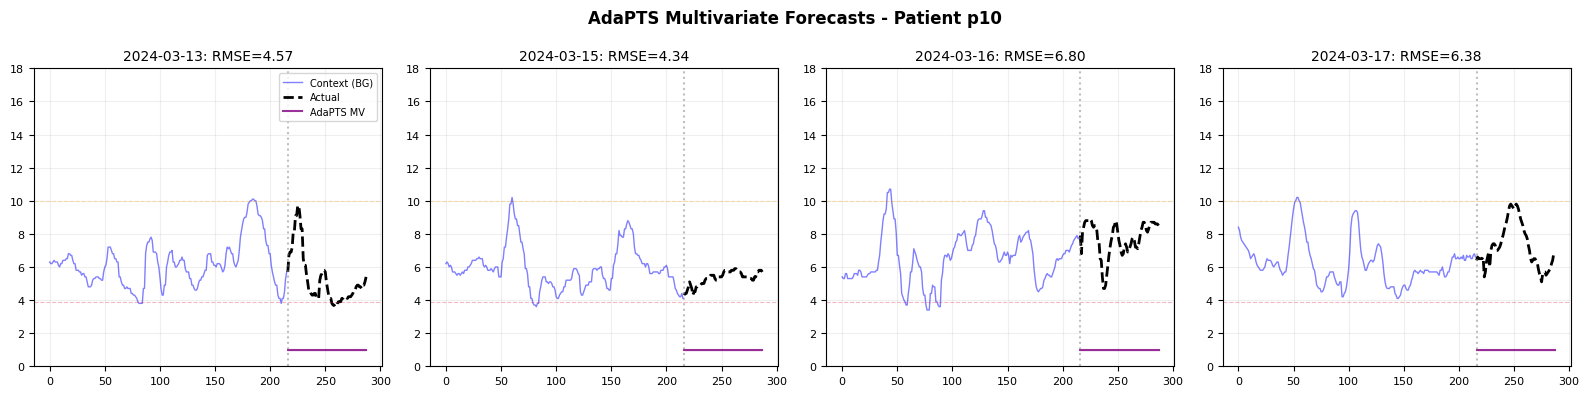


AdaPTS Multivariate Results for Patient p10:
  Days evaluated: 4
  Avg RMSE: 5.522 mmol/L


In [11]:
# Plot AdaPTS multivariate forecasts
n_days = len(mv_forecasts)
nrows = int(np.ceil(n_days / NCOLS))

fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 4 * nrows))
axes = np.array(axes).flatten() if n_days > 1 else [axes]

for i, forecast in enumerate(mv_forecasts):
    ax = axes[i]
    
    # Show last 216 steps of context
    ctx_display = forecast["context"][-216:]
    t_ctx = np.arange(len(ctx_display))
    t_pred = np.arange(len(ctx_display), len(ctx_display) + len(forecast["target"]))
    
    # Context and target
    ax.plot(t_ctx, ctx_display, "b-", alpha=0.5, lw=1, label="Context (BG)")
    ax.plot(t_pred, forecast["target"], "k--", lw=2, label="Actual")
    
    # Multivariate forecast (purple)
    ax.plot(t_pred, forecast["pred_mv"], "purple", lw=1.5, alpha=0.8, label="AdaPTS MV")
    ax.fill_between(t_pred, forecast["lb_mv"], forecast["ub_mv"], 
                    alpha=0.15, color="purple")
    
    ax.axvline(len(ctx_display), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)
    ax.axhline(10.0, color="orange", ls="--", alpha=0.3, lw=0.8)
    
    ax.set_title(f"{forecast['date']}: RMSE={forecast['rmse_mv']:.2f}", fontsize=10)
    ax.set_ylim(0, 18)
    ax.tick_params(labelsize=8)
    ax.grid(alpha=0.2)

# Hide unused subplots
for j in range(n_days, len(axes)):
    axes[j].set_visible(False)

axes[0].legend(fontsize=7, loc="upper right")
fig.suptitle(f"AdaPTS Multivariate Forecasts - Patient {PLOT_PATIENT}", 
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# Summary
print(f"\nAdaPTS Multivariate Results for Patient {PLOT_PATIENT}:")
print(f"  Days evaluated: {len(mv_forecasts)}")
print(f"  Avg RMSE: {np.mean([f['rmse_mv'] for f in mv_forecasts]):.3f} mmol/L")

## Summary

### AdaPTS Multivariate Forecasting

| Feature | Description |
|---------|-------------|
| **Input Features** | BG, IOB, COB, steps, calories |
| **Model** | TimesFM v1 (200M) + VAE Adapter |
| **Latent Space** | 3 components |
| **Training** | Adapter fitted on training windows |

### Key Findings

1. **AdaPTS enables multivariate forecasting** by learning latent projections
2. **Covariates (IOB, COB, activity)** can improve predictions when patterns exist
3. **Requires TimesFM v1 API** - incompatible with v2.5